In [1]:
import datetime as datetime
import pandas as pd
import numpy as np
#import numpy_financial as npf
from itertools import accumulate
import absbox as abs
from absbox import API, SPV, Generic, mkDealsBy, setDealsBy,prodDealsBy, viz, readBondsCf      #, Portfolio, Risk, Performance, Utils, Data, Analytics, Market, Risk, Utils, Data, Analytics, Market
from absbox.local.analytics import irr, run_yield_table, flow_by_scenario       #npv, 
from absbox.local.util import positionFlow
from dateutil.relativedelta import relativedelta  
from tabulate import tabulate
from itertools import accumulate
from pyxirr import xirr
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  
from mpl_toolkits.mplot3d import axes3d
import time
#from scipy import optimize
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter  
#import seaborn as sns   
import warnings
from lenses import lens
#import plotly.graph_objects as go
#import plotly.express as px
import math

warnings.filterwarnings('ignore')
localAPI = API("http://localhost:8081",check=False)

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.set_option('display.max_rows', None)

Connecting engine server -> http://localhost:8081

✅Connected, local lib:0.28.7, server:0.29.10

Old Model

In [7]:
# Pool assumptions 
original_pool_balance = 1_000_000
original_pool_term = 72
seasoning = 0
base_rate = 0 # float(prcEnv.ratesCurves['EUR'].instFwd(valDate.addTenor('0D')))
pool_rate = 0.03 + base_rate
default_rate = 0.0013     #0.002  #[0.03]*36 + [0.01]*36    # [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
# defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
pool_cpr = 0.15  # amortization rate, 12 / original_pool_term 
recovery_rate = 0.00  # 1 - (0.3 * 0.7 + 0.15 * 0.3)  
recovery_lag = 0   

# Deal assumptions
start_date = '2024-11-15'
original_deal_term = 60
repay_month = 3
months_to_call = repay_month
tranche_size_equity = 0.005
tranche_size_mezz = 0.051
tranche_size_senior = 1 - tranche_size_equity - tranche_size_mezz
tranche_rate_equity = 0.00 + base_rate   
tranche_rate_mezz = 0.07 + base_rate
tranche_rate_senior = 0
issue_price = 1
reinvestment_rate = 0.00
switch_trigger = "cumPoolNetLossRate"   # [("cumPoolDefaultedRate",),">",0.05]] 
switch_level = 0.02 
clean_up_call = 0.1

# Remaining calcs
first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+3)  
first_pay_date = first_pay_date.strftime('%Y-%m-%d')
repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
repay_date = repay_date.strftime('%Y-%m-%d')  
deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
deal_call_date = deal_call_date.strftime('%Y-%m-%d')  
pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  

In [155]:
mortgage1 = ["Mortgage"             #this is a factual snapshot at issuance, confirmed unchanged.
        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"Even","originDate":start_date} 
        ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term - seasoning,"status":"current"}]
revolvingPool = (["constant",mortgage1],("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None))
perf = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None)     # this is for new assets added into the pool

Resonance = Generic("TEST01"
    ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} 
    ,{'assets':[mortgage1],'issuanceStat':{"IssuanceBalance":original_pool_balance}}
    ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  
    ,(("S",{"balance":original_pool_balance * tranche_size_senior, "rate":tranche_rate_senior,"originBalance":original_pool_balance * tranche_size_senior
      ,"originRate":tranche_rate_senior,"startDate":start_date,"rateType":{"Fixed":tranche_rate_senior},"bondType":{"Sequential":None}})
     ,("M",{"balance":original_pool_balance * tranche_size_mezz,"rate":tranche_rate_mezz,"originBalance":original_pool_balance * tranche_size_mezz
      ,"originRate":tranche_rate_mezz,"startDate":start_date,"rateType":{"Fixed":tranche_rate_mezz},"bondType":{"Sequential":None}})                 
     ,("E",{"balance":original_pool_balance * tranche_size_equity,"rate":tranche_rate_equity,"originBalance":original_pool_balance * tranche_size_equity
      ,"originRate":tranche_rate_equity,"startDate":start_date,"rateType":{"Fixed":tranche_rate_equity}, "bondType":{"Sequential":None}}))
    ,list()
    ,{"revolving":[["accrueAndPayIntBySeq","acc02",["S","M","E"]],['transfer',"acc02","acc01"] # ,['WriteOff',["E","M","S"]]                                             # this is the write off of the defaulted assets
      # ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("-",("originalPoolBalance",),("poolBalance",))}]]    # ("cumPoolCollection", None, "CollectedPrincipal","CollectedPrepayment")     # None can be replaced with small pools 
      ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("curPoolCollection",None,"CollectedPrincipal","CollectedPrepayment")}]]    # ("cumPoolCollection", None, "CollectedPrincipal","CollectedPrepayment")     # None can be replaced with small pools 
      ,"amortizing":[["accrueAndPayIntBySeq","acc02",["S","M","E"]], ['transfer',"acc02","acc01"]
      # ,['payPrinBySeq',"acc01",["S","M","E"]], ['WriteOff',["E","M","S"]]
      ,['payPrin',"acc01",["S","M","E"]], ['payIntResidual',"acc01","E"]]}
    ,[["CollectedPrincipal","acc01"],["CollectedRecoveries","acc01"],["CollectedPrepayment","acc01"],["CollectedInterest","acc02"]]
    ,None,None,None
    ,{"BeforeDistribution":{"dealStatusChange":{"condition":["any",[">=",repay_date],[(switch_trigger,),">",switch_level]]
      ,"effects":("newStatus","Amortizing"),"status":False,"curable":False}}}
    ,("PreClosing","Revolving"))

# Asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance. below is what the new assets look like
runDealAssump = [("revolving",["constant",["Mortgage"     
                  ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"Level","originDate":repay_date}
                  ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term,"status":"current"}]],perf)
                ,("call",{"poolFactor":clean_up_call})]

r = localAPI.run(Resonance,runAssump = runDealAssump,poolAssump = ("Pool",("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None),read=True)

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

In [156]:
bond_cf = readBondsCf(r['bonds'])
bond_cf.iloc[0, bond_cf.columns.get_loc(('M', 'cash'))] = -bond_cf.iloc[0, bond_cf.columns.get_loc(('M', 'balance'))]
bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'cash'))] = bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'balance'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'interest'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'principal'))]
bond_cf.tail()
irr = xirr(bond_cf.index.to_list(), bond_cf['M', 'cash'].to_list())
irr

0.07228914522482051

Sensitivity Test v1

In [159]:
# Sensitivity Test Using readBondsCf(r['bonds'])
cprs = np.arange(0.00, 0.35, 0.05).tolist()
spreads = np.arange(0.04, 0.08, 0.005).tolist()
results = []

for pool_cpr in cprs:
   for tranche_rate_mezz in spreads:
        mortgage1 = ["Mortgage"             #this is a factual snapshot at issuance, confirmed unchanged.
                ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"Even","originDate":start_date} 
                ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term - seasoning,"status":"current"}]
        revolvingPool = (["constant",mortgage1],("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None))
        perf = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None)     # this is for new assets added into the pool

        Resonance = Generic("TEST01"
            ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} 
            ,{'assets':[mortgage1],'issuanceStat':{"IssuanceBalance":original_pool_balance}}
            ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  
            ,(("S",{"balance":original_pool_balance * tranche_size_senior, "rate":tranche_rate_senior,"originBalance":original_pool_balance * tranche_size_senior
            ,"originRate":tranche_rate_senior,"startDate":start_date,"rateType":{"Fixed":tranche_rate_senior},"bondType":{"Sequential":None}})
            ,("M",{"balance":original_pool_balance * tranche_size_mezz,"rate":tranche_rate_mezz,"originBalance":original_pool_balance * tranche_size_mezz
            ,"originRate":tranche_rate_mezz,"startDate":start_date,"rateType":{"Fixed":tranche_rate_mezz},"bondType":{"Sequential":None}})                 
            ,("E",{"balance":original_pool_balance * tranche_size_equity,"rate":tranche_rate_equity,"originBalance":original_pool_balance * tranche_size_equity
            ,"originRate":tranche_rate_equity,"startDate":start_date,"rateType":{"Fixed":tranche_rate_equity}, "bondType":{"Sequential":None}}))
            ,list()
            ,{"revolving":[["accrueAndpayPrinBySeqPayIntBySeq","acc02",["S","M","E"]],['transfer',"acc02","acc01"] # ,['WriteOff',["E","M","S"]]                                             # this is the write off of the defaulted assets
            # ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("-",("originalPoolBalance",),("poolBalance",))}]]    # ("cumPoolCollection", None, "CollectedPrincipal","CollectedPrepayment")     # None can be replaced with small pools 
            ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("curPoolCollection",None,"CollectedPrincipal","CollectedPrepayment")}]]    # ("cumPoolCollection", None, "CollectedPrincipal","CollectedPrepayment")     # None can be replaced with small pools 
            ,"amortizing":[["accrueAndPayIntBySeq","acc02",["S","M","E"]], ['transfer',"acc02","acc01"]
            # ,['payPrinBySeq',"acc01",["S","M","E"]], ['WriteOff',["E","M","S"]]
            ,['payPrin',"acc01",["S","M","E"]], ['payIntResidual',"acc01","E"]]}
            ,[["CollectedPrincipal","acc01"],["CollectedRecoveries","acc01"],["CollectedPrepayment","acc01"],["CollectedInterest","acc02"]]
            ,None,None,None
            ,{"BeforeDistribution":{"dealStatusChange":{"condition":["any",[">=",repay_date],[(switch_trigger,),">",switch_level]]
            ,"effects":("newStatus","Amortizing"),"status":False,"curable":False}}}
            ,("PreClosing","Revolving"))

        # Asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance. below is what the new assets look like
        runDealAssump = [("revolving",["constant",["Mortgage"     
                        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"Level","originDate":repay_date}
                        ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term,"status":"current"}]],perf)
                        ,("call",{"poolFactor":clean_up_call})]

        r = localAPI.run(Resonance,runAssump = runDealAssump,poolAssump = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None),read=True)

        bond_cf = readBondsCf(r['bonds'])
        bond_cf.iloc[0, bond_cf.columns.get_loc(('M', 'cash'))] = -bond_cf.iloc[0, bond_cf.columns.get_loc(('M', 'balance'))]
        bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'cash'))] = bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'balance'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'interest'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('M', 'principal'))]
        bond_cf.tail()
        result = xirr(bond_cf.index.to_list(), bond_cf['M', 'cash'].to_list())
        results.append({'pool_cpr': pool_cpr*100, 'tranche_rate_mezz': tranche_rate_mezz*100, 'IRR': result*100})
        print(f"Pool CPR: {pool_cpr*100}, Tranche Rate: {tranche_rate_mezz*100}, IRR: {result*100}")


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 4.0, IRR: 4.073999049658834


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 4.5, IRR: 4.593824352917886


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 5.0, IRR: 5.115934503187076


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 5.499999999999999, IRR: 5.640558071079428


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 5.999999999999999, IRR: 6.167548607512492


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 6.499999999999999, IRR: 6.696986127220721


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 6.999999999999998, IRR: 7.2288146806669396


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 7.499999999999998, IRR: 7.76310681165961


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 4.0, IRR: 4.073946743066094


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 4.5, IRR: 4.593797681817138


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 5.0, IRR: 5.115945449124064


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 5.499999999999999, IRR: 5.640554622016344


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 5.999999999999999, IRR: 6.167549990750056


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 6.499999999999999, IRR: 6.696998760098754


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 6.999999999999998, IRR: 7.228770327635842


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 5.0, Tranche Rate: 7.499999999999998, IRR: 7.763103247676437


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 4.0, IRR: 4.073952191096051


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 4.5, IRR: 4.593785921951018


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 5.0, IRR: 5.115901572182075


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 5.499999999999999, IRR: 5.64051056750687


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 5.999999999999999, IRR: 6.167536767709341


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 6.499999999999999, IRR: 6.696967910314523


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 6.999999999999998, IRR: 7.22879588792567


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 10.0, Tranche Rate: 7.499999999999998, IRR: 7.76309177284283


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 4.0, IRR: 4.073885172303015


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 4.5, IRR: 4.5937513138842725


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 5.0, IRR: 5.115859359550489


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 5.499999999999999, IRR: 5.640487455012845


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 5.999999999999999, IRR: 6.167541595682781


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 6.499999999999999, IRR: 6.696982720506142


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 6.999999999999998, IRR: 7.228819904717573


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 7.499999999999998, IRR: 7.763102686791577


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 4.0, IRR: 4.0739060825590965


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 4.5, IRR: 4.593801762537687


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 5.0, IRR: 5.1158882968350206


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 5.499999999999999, IRR: 5.64053779564292


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 5.999999999999999, IRR: 6.167509260688244


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 6.499999999999999, IRR: 6.696984925253763


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 6.999999999999998, IRR: 7.228843322002164


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 20.0, Tranche Rate: 7.499999999999998, IRR: 7.763117370175482


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 4.0, IRR: 4.073877113372429


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 4.5, IRR: 4.593776321030487


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 5.0, IRR: 5.115948248579021


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 5.499999999999999, IRR: 5.640569369446298


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 5.999999999999999, IRR: 6.167548457833467


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 6.499999999999999, IRR: 6.69697943792521


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 6.999999999999998, IRR: 7.228832049799229


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 25.0, Tranche Rate: 7.499999999999998, IRR: 7.763167109965358


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 4.0, IRR: 4.073955450664254


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 4.5, IRR: 4.593786642124275


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 5.0, IRR: 5.115908380320338


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 5.499999999999999, IRR: 5.640534301344707


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 5.999999999999999, IRR: 6.1675515093777245


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 6.499999999999999, IRR: 6.6970273722417835


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 6.999999999999998, IRR: 7.228897552743316


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 7.499999999999998, IRR: 7.763197758839323


In [160]:
results_df = pd.DataFrame(results)
results_df.to_clipboard(index=False)
pivoted_df = results_df.pivot(index='pool_cpr', columns='tranche_rate_mezz', values='IRR')
pivoted_df

tranche_rate_mezz,4.000,4.500,5.000,5.500,6.000,6.500,7.000,7.500
pool_cpr,,,,,,,,
0.000,4.074,4.594,5.116,5.641,6.168,6.697,7.229,7.763
5.000,4.074,4.594,5.116,5.641,6.168,6.697,7.229,7.763
10.000,4.074,4.594,5.116,5.641,6.168,6.697,7.229,7.763
15.000,4.074,4.594,5.116,5.640,6.168,6.697,7.229,7.763
20.000,4.074,4.594,5.116,5.641,6.168,6.697,7.229,7.763
25.000,4.074,4.594,5.116,5.641,6.168,6.697,7.229,7.763
30.000,4.074,4.594,5.116,5.641,6.168,6.697,7.229,7.763


Sensitivity Test v2

In [161]:
def bondIrr(result):
    clo_like_equity_tranche = result['bonds']['E']['cash']
    initial_investment = original_pool_balance * tranche_size_equity * issue_price
    clo_like_equity_tranche = pd.concat([pd.Series(-1*initial_investment, index=[start_date]), clo_like_equity_tranche])
    clo_like_equity_tranche.sort_index(inplace=True)
    return xirr(clo_like_equity_tranche.index.to_list(),clo_like_equity_tranche.to_list())

def tryDraw(txns ,bal , draws):
    if len(draws)==0:
        return txns
    else:
        draw = draws[0]
        restDraws = draws[1:]
        if bal >= draw:
            return tryDraw(txns+[draw],bal-draw,restDraws)
        else:
            return tryDraw(txns+[bal],0,restDraws)

def srt(initBals, poolPerformance, trancheOfIntest, feeRates, reinvestRate=reinvestment_rate):
    
    poolDates = poolPerformance['pool']['flow'].index.to_list()
    beginDate = poolDates[0]
    lastDate = poolDates[-1]
    start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
    start['CumLossDerived'] = start['Loss'].cumsum()

    seniorBal, mezzBal, equityBal = initBals
    mezzRate,equityRate = feeRates
    
    issuePrice = mezzBal if trancheOfIntest == "M" else equityBal
    
    # indicator only     #this considers the loss resulted writeoffs
    start.loc[:,'equityBal'] = (equityBal - start['CumLossDerived']).clip(lower=0).to_list()
    start.loc[:,'mezzBal'] =  mezzBal - (start['CumLossDerived'] - equityBal).clip(lower=0,upper=mezzBal)
    start.loc[:,'seniorBal'] = seniorBal - (start['CumLossDerived'] - equityBal - mezzBal).clip(lower=0)
    start.loc[:,'mezzLoss'] = np.maximum(start['CumLossDerived'] - equityBal, 0).clip(lower=0).to_list()  
    start.loc[:,'seniorLoss'] = np.maximum(start['CumLossDerived'] - equityBal - mezzBal, 0).clip(lower=0).to_list()  

    if trancheOfIntest == "M" :     #shows which tranche we're investing in
        start.loc[:,'mezzBal - feeStream'] = start['mezzBal'] * mezzRate / 12
    else:
        start.loc[:,'equityBal - feeStream'] = start['equityBal'] * equityRate / 12

    #start.loc[:,'reimburseLoss'] = start['Loss']

    # invest related cashflow
    start.loc[:,'cashAccountChange'] = 0
    ## account init bals
    start.loc[:,'cashAccountBal'] = issuePrice
    ## loss reimbursement
    start.loc[:,'reimburseLoss'] = 0

    if trancheOfIntest == "M" :     #shows which tranche we're investing in
        reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'mezzLoss'].to_list())
    else:
        reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'Loss'].to_list())
    
    start.loc[:,'reimburseLoss'] = reimburseAmt
    start.loc[:,'cashAccountChange'] = start.loc[:,'cashAccountChange'] + -1*start['reimburseLoss']
    ## init deposit with price
    start.loc[beginDate, 'cashAccountChange'] = start.loc[beginDate, 'cashAccountChange'] + issuePrice
    ### calculate account balance with 
    start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
    ### withdraw all cash from account at last day
    start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'cashAccountBal']
    ## reinvestment int
    start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
    ## net cashflow
    start.loc[:,'netCashflow'] = 0 
    # the above takes care of the 2 sources of inflows: guarantee fee income and cash account reinvestment interest
    
    ## init deposit
    start.loc[beginDate,'netCashflow'] = -1 * issuePrice
    ## add premiums to net cashflow
    if trancheOfIntest == "M" :
        start.loc[:,'netCashflow'] += start['mezzBal - feeStream'].fillna(0)
    else:
        start.loc[:,'netCashflow'] += start['equityBal - feeStream'].fillna(0)
    ## add reinvestment int to net cashflow
    start.loc[:,'netCashflow'] += start['cashAccountInt']
    ## draw remain cash from account at last period
    start.loc[lastDate,'netCashflow'] += start.loc[lastDate,'cashAccountBal']    
    return start

stackPortion = (tranche_size_senior,tranche_size_mezz,tranche_size_equity)
ganranteeFeeRates = (tranche_rate_mezz,tranche_rate_equity)
projectCf = srt( [ original_pool_balance * x for x in stackPortion ]
                , r, "M", ganranteeFeeRates, reinvestRate=reinvestment_rate)
projectCf
xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())

0.0806173652981258

In [162]:
# Sensitivity Analysis
default_rates = np.arange(0.00, 0.03, 0.0005).tolist()
cprs = np.arange(0.00, 0.35, 0.05).tolist()
spreads = np.arange(0.04, 0.08, 0.005).tolist()
# default_rate = [0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 

results = []
# for default_rate in default_rates:
for pool_cpr in cprs:
   for tranche_rate_mezz in spreads:
        perf = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None) 

        Resonance = Generic("TEST01"
         ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} 
         ,{'assets':[mortgage1],'issuanceStat':{"IssuanceBalance":original_pool_balance}}
         ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  
         ,(("S",{"balance":original_pool_balance * tranche_size_senior, "rate":tranche_rate_senior,"originBalance":original_pool_balance * tranche_size_senior
            ,"originRate":tranche_rate_senior,"startDate":start_date,"rateType":{"Fixed":tranche_rate_senior},"bondType":{"Sequential":None}})
         ,("M",{"balance":original_pool_balance * tranche_size_mezz,"rate":tranche_rate_mezz,"originBalance":original_pool_balance * tranche_size_mezz
            ,"originRate":tranche_rate_mezz,"startDate":start_date,"rateType":{"Fixed":tranche_rate_mezz},"bondType":{"Sequential":None}})                                     # change rateType to Floating 
         ,("E",{"balance":original_pool_balance * tranche_size_equity,"rate":tranche_rate_equity,"originBalance":original_pool_balance * tranche_size_equity
            ,"originRate":tranche_rate_equity,"startDate":start_date,"rateType":{"Fixed":tranche_rate_equity}, "bondType":{"Sequential":None}}))
         ,list()
         ,{"revolving":[["accrueAndPayIntBySeq","acc02",["S","M","E"]],['transfer',"acc02","acc01"] # ,['WriteOff',["E","M","S"]]                                             # this is the write off of the defaulted assets
            # ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("-",("originalPoolBalance",),("poolBalance",))}]]    # ("cumPoolCollection", None, "CollectedPrincipal","CollectedPrepayment")     # None can be replaced with small pools 
            ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("curPoolCollection",None,"CollectedPrincipal","CollectedPrepayment")}]]    # ("cumPoolCollection", None, "CollectedPrincipal","CollectedPrepayment")     # None can be replaced with small pools 
            ,"amortizing":[["accrueAndPayIntBySeq","acc02",["S","M","E"]], ['transfer',"acc02","acc01"]
            # ,['payPrinBySeq',"acc01",["S","M","E"]], ['WriteOff',["E","M","S"]]
            ,['payPrin',"acc01",["S","M","E"]], ['payIntResidual',"acc01","E"]]}
         ,[["CollectedPrincipal","acc01"],["CollectedRecoveries","acc01"],["CollectedPrepayment","acc01"],["CollectedInterest","acc02"]]
         ,None,None,None
         ,{"BeforeDistribution":{"dealStatusChange":{"condition":["any",[">=",repay_date],[(switch_trigger,),">",switch_level]]                                                 
            ,"effects":("newStatus","Amortizing"),"status":False,"curable":False}}}
         ,("PreClosing","Revolving"))

        r = localAPI.run(Resonance,runAssump = runDealAssump,poolAssump = ("Pool",("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None),read=True)
        projectCf = srt( [ original_pool_balance * x for x in stackPortion ], r, "M", ganranteeFeeRates, reinvestRate=reinvestment_rate)
        result = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
        results.append(result)
      #   print(f"Default Rate: {default_rate}, IRR: {result}")
        print(f"Pool CPR: {pool_cpr}, Tranche Rate: {tranche_rate_mezz}, IRR: {result}")


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.0, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.05, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.1, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.15000000000000002, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.2, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.25, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.04, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.045, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.049999999999999996, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.05499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.05999999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.06499999999999999, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.06999999999999998, IRR: 0.08003399865914239


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Pool CPR: 0.30000000000000004, Tranche Rate: 0.07499999999999998, IRR: 0.08003399865914239


In [165]:
results

[0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.08003399865914239,
 0.0800339

In [166]:
def srt(r):
    stackPortion = (tranche_size_senior,tranche_size_mezz,tranche_size_equity)
    bal_s = original_pool_balance * tranche_size_senior
    bal_m = original_pool_balance * tranche_size_mezz
    bal_e = original_pool_balance * tranche_size_equity
    pool_dates = r['pool']['flow'].index.to_list()
    start_date = pool_dates[0]
    end_date = pool_dates[-1]
    start = r['pool']['flow'][['Balance','Loss','CumLoss','Principal','Prepayment']]

    start.loc[start_date, 'Balance'] = original_pool_balance
    start.loc[:,'Principal'] = np.where(start.index < repay_date, 0, start['Principal'])
    start.loc[:,'Prepayment'] = np.where(start.index < repay_date, 0, start['Prepayment'])
    start.loc[:,'Balance'] = np.where(start.index < repay_date, original_pool_balance - start['CumLoss'], original_pool_balance - start['CumLoss'] - start['Principal'].cumsum() - start['Prepayment'].cumsum())

    start.loc[:,'equity_loss'] = np.minimum(np.maximum(start['CumLoss'], 0).clip(lower=0), bal_e).clip(lower=0).to_list() 
    start.loc[:,'mezz_loss'] = np.minimum(np.maximum(start['CumLoss'] - bal_e, 0).clip(lower=0), bal_m).clip(lower=0).to_list() 
    start.loc[:,'senior_loss'] = np.minimum(np.maximum(start['CumLoss'] - bal_e - bal_m, 0).clip(lower=0), bal_s).clip(lower=0).to_list() 
    start.loc[:,'equity_loss_reimbursed'] = start.loc[:,'equity_loss'] - start.loc[:,'equity_loss'].shift(1)
    start.loc[:,'mezz_loss_reimbursed'] = start.loc[:,'mezz_loss'] - start.loc[:,'mezz_loss'].shift(1)
    start.loc[:,'senior_loss_reimbursed'] = start.loc[:,'senior_loss'] - start.loc[:,'senior_loss'].shift(1)

    start.loc[:,'principal_repayment'] = start['Balance'].shift(1) - start['Balance'] - start['Loss']
    start.loc[:,'equity_principal'] = start['principal_repayment'] * tranche_size_equity 
    start.loc[:,'mezz_principal'] = start['principal_repayment'] * tranche_size_mezz 
    start.loc[:,'senior_principal'] = start['principal_repayment'] * tranche_size_senior 

    start.loc[:,'equity_bal'] = bal_e
    start.loc[:,'mezz_bal'] = bal_m
    start.loc[:,'senior_bal'] = bal_s
    start.loc[:,'equity_bal'] = np.maximum(0, start['equity_bal'].shift(0) - (start['equity_principal'] + start['equity_loss_reimbursed']).cumsum())
    start.loc[:,'mezz_bal'] = np.maximum(0, start['mezz_bal'].shift(0) - (start['mezz_principal'] + start['mezz_loss_reimbursed']).cumsum())
    start.loc[:,'senior_bal'] = np.maximum(0, start['senior_bal'].shift(0) - (start['senior_principal'] + start['senior_loss_reimbursed']).cumsum())

    start.loc[:,'equity_coupon'] = start['equity_bal'] * tranche_rate_equity / 12 
    start.loc[:,'mezz_coupon'] = start['mezz_bal'] * tranche_rate_mezz / 12 
    start.loc[:,'senior_coupon'] = start['senior_bal'] * tranche_rate_senior / 12 

    start.loc[:,'equity_cash_account_bal'] = bal_e
    start.loc[:,'mezz_cash_account_bal'] = bal_m
    start.loc[:,'senior_cash_account_bal'] = bal_s
    start.loc[:,'equity_cash_account_change'] = 0 
    start.loc[:,'mezz_cash_account_change'] = 0   
    start.loc[:,'senior_cash_account_change'] = 0 
    start['equity_cash_account_change'] = np.where(start['equity_bal'] <= 0, 0, start['equity_cash_account_change'] + (-1 * start['equity_loss_reimbursed']) + (-1 * start['equity_principal']))
    start['mezz_cash_account_change'] = np.where(start['mezz_bal'] <= 0, 0, start['mezz_cash_account_change'] + (-1 * start['mezz_loss_reimbursed']) + (-1 * start['mezz_principal']))
    start['senior_cash_account_change'] = np.where(start['senior_bal'] <= 0, 0, start['senior_cash_account_change'] + (-1 * start['senior_loss_reimbursed']) + (-1 * start['senior_principal']))
    start.loc[start_date, 'equity_cash_account_change'] = -bal_e
    start.loc[start_date, 'mezz_cash_account_change'] = -bal_m
    start.loc[start_date, 'senior_cash_account_change'] = -bal_s
    start.loc[:,'equity_cash_account_bal'] = list(accumulate([bal_e] + (start['equity_cash_account_change']).to_list()[1:]))
    start.loc[:,'mezz_cash_account_bal'] = list(accumulate([bal_m] + start['mezz_cash_account_change'].to_list()[1:]))            # + start['mezz_principal'].to_list()[1:]
    start.loc[:,'senior_cash_account_bal'] = list(accumulate([bal_s] + start['senior_cash_account_change'].to_list()[1:]))        # + start['senior_principal'].to_list()[1:]
    start.loc[end_date, 'equity_cash_account_change'] = 1*start.loc[end_date, 'equity_cash_account_bal']                                   ## withdraw all cash from account at last day
    start.loc[end_date, 'mezz_cash_account_change'] = 1*start.loc[end_date, 'mezz_cash_account_bal']                                       ## withdraw all cash from account at last day
    start.loc[end_date, 'senior_cash_account_change'] = 1*start.loc[end_date, 'senior_cash_account_bal']                                   ## withdraw all cash from account at last day
    start.loc[:,'equity_cash_account_int'] = start['equity_cash_account_bal'].shift(1,fill_value=0) * reinvestment_rate/12
    start.loc[:,'mezz_cash_account_int'] = start['mezz_cash_account_bal'].shift(1,fill_value=0) * reinvestment_rate/12
    start.loc[:,'senior_cash_account_int'] = start['senior_cash_account_bal'].shift(1,fill_value=0) * reinvestment_rate/12
    start.loc[:,'NCF_e'] = 0
    start.loc[:,'NCF_m'] = 0
    start.loc[:,'NCF_s'] = 0
    start.loc[start_date,'NCF_e'] = -1 * bal_e
    start.loc[start_date,'NCF_m'] = -1 * bal_m
    start.loc[start_date,'NCF_s'] = -1 * bal_s
    start.loc[:,'NCF_e'] += start['equity_coupon'].fillna(0) + start['equity_principal'].fillna(0)                       ## add premiums to net cashflow for the tranche
    start.loc[:,'NCF_m'] += start['mezz_coupon'].fillna(0) + start['mezz_principal'].fillna(0)                           ## add premiums to net cashflow for the tranche
    start.loc[:,'NCF_s'] += start['senior_coupon'].fillna(0) + start['senior_principal'].fillna(0)                       ## add premiums to net cashflow for the tranche
    start.loc[:,'NCF_e'] += start['equity_cash_account_int']                        ## add reinvestment intto net cashflow for the tranche
    start.loc[:,'NCF_m'] += start['mezz_cash_account_int']                        ## add reinvestment intto net cashflow for the tranche
    start.loc[:,'NCF_s'] += start['senior_cash_account_int']                        ## add reinvestment intto net cashflow for the tranche
    start.loc[end_date,'NCF_e'] += start.loc[end_date,'equity_cash_account_bal']    ## draw remain cash from account at last period
    start.loc[end_date,'NCF_m'] += start.loc[end_date,'mezz_cash_account_bal']    ## draw remain cash from account at last period
    start.loc[end_date,'NCF_s'] += start.loc[end_date,'senior_cash_account_bal']    ## draw remain cash from account at last period
    return start

def run_analysis(r):
    start = srt(r)
    irr_e = xirr(start.index.to_list(),start['NCF_e'].to_list())
    irr_m = xirr(start.index.to_list(),start['NCF_m'].to_list())
    irr_s = xirr(start.index.to_list(),start['NCF_s'].to_list())
    tranches = ['E', 'M', 'S']
    irr_values = [irr_e, irr_m, irr_s]
    data = [{'Tranche': tranche, 'IRR': irr_values[i]} for i, tranche in enumerate(tranches)]
    results = pd.DataFrame(data)
    results['IRR'] = results['IRR'].apply(lambda x: f"{round(x * 100, 2)}%")
    results_unpivoted = results.pivot_table(index=None, columns='Tranche', values='IRR', aggfunc='first')
    results_unpivoted.columns = [f"IRR_{col}" for col in results_unpivoted.columns]
    results_unpivoted = results_unpivoted.reset_index(drop=True)
    results_unpivoted['CDR'] = f"{default_rate * 100:.1f}%"
    return results_unpivoted

start = srt(r)
results = run_analysis(r)
results

,IRR_E,IRR_M,IRR_S,CDR
0,-6.61%,7.72%,-0.0%,0.1%


In [167]:
r['pool']['flow'].to_clipboard()
r['pool']['flow'].head()

readBondsCf(r['bonds']).to_clipboard()
readBondsCf(r['bonds']).head(5)

start.to_clipboard()
start.head(5)

,Balance,Loss,CumLoss,Principal,Prepayment,equity_loss,mezz_loss,senior_loss,equity_loss_reimbursed,mezz_loss_reimbursed,...,senior_cash_account_bal,equity_cash_account_change,mezz_cash_account_change,senior_cash_account_change,equity_cash_account_int,mezz_cash_account_int,senior_cash_account_int,NCF_e,NCF_m,NCF_s
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-15,"1,000,000.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,...,"944,000.000","-5,000.000","-51,000.000","-944,000.000",0.000,0.000,0.000,"-5,000.000","-51,000.000","-944,000.000"
2024-11-30,"1,000,000.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,"944,000.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,318.750,0.000
2024-12-31,"999,893.090",106.910,106.910,0.000,0.000,106.910,0.000,0.000,106.910,0.000,...,"944,000.000",-106.910,-0.000,-0.000,0.000,0.000,0.000,0.000,318.750,0.000
2025-01-31,"999,784.160",108.930,215.840,0.000,0.000,215.840,0.000,0.000,108.930,0.000,...,"944,000.000",-108.930,0.000,0.000,0.000,0.000,0.000,-0.000,318.750,-0.000
2025-02-28,"985,792.450",107.380,323.220,"13,884.330",0.000,323.220,0.000,0.000,107.380,0.000,...,"930,893.192",-176.802,-708.101,"-13,106.808",0.000,0.000,0.000,69.422,"1,022.425","13,106.808"


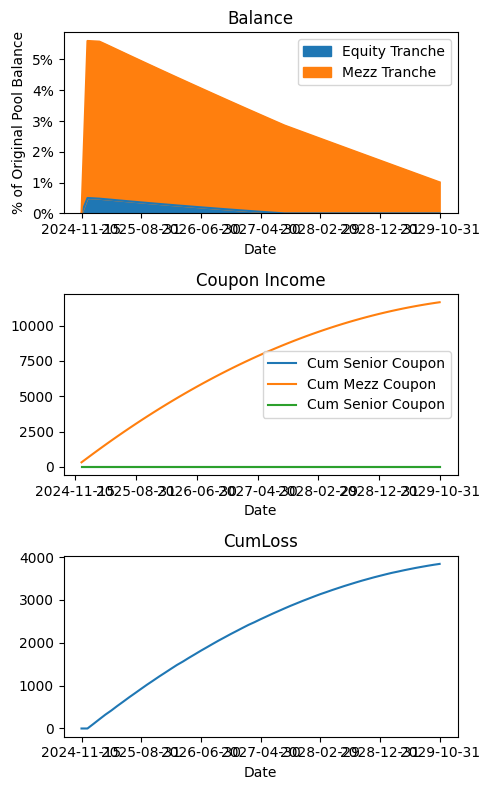

In [168]:
fig, ax = plt.subplots(3, 1, figsize=(5, 8))

# First chart: "Balance"
start['Equity Tranche'] = start['equity_bal'] / original_pool_balance
start['Mezz Tranche'] = start['mezz_bal'] / original_pool_balance
start['senior_pct'] = start['senior_bal'] / original_pool_balance
start[['Equity Tranche', 'Mezz Tranche']].plot(kind='area', stacked=True, ax=ax[0], title='Balance')
ax[0].set_ylabel('% of Original Pool Balance')
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))  

# Second chart: cumulative values of "mezz_coupon" and "senior_coupon"
start['senior_coupon'].cumsum().plot(ax=ax[1], label='Cum Senior Coupon')
start['mezz_coupon'].cumsum().plot(ax=ax[1], label='Cum Mezz Coupon')
start['senior_coupon'].cumsum().plot(ax=ax[1], label='Cum Senior Coupon')
ax[1].set_title('Coupon Income')
ax[1].legend()

# Third chart: "CumLoss"
start['CumLoss'].plot(ax=ax[2], title='CumLoss')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the charts
plt.show()

In [169]:
# moic = start['NCF_m'].cumsum() + original_pool_balance * tranche_size_equity * issue_price
# moic = moic.tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# moic

defaults = r['pool']['flow']['CumDefault'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
defaults
# recoveries = r['pool']['flow']['CumRecovery'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# recoveries
# losses = r['pool']['flow']['CumLoss'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# losses

Date
2029-10-31   0.768
Name: CumDefault, dtype: float64

In [170]:
# Sensitivity Analysis
default_rates = np.arange(0.00, 0.12, 0.005).tolist()  
# default_rate = [0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 

results = []
for default_rate in default_rates:
        perf = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None) 
        r = localAPI.run(Resonance,runAssump = runDealAssump,poolAssump = ("Pool",("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None),read=True)
        results.append(run_analysis(r))
results = pd.concat(results)
results['Deal Name'] = 'Resonance'
results = results.reset_index(drop=True)
results.to_csv('sensitivity_analysis.csv', index=False)


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

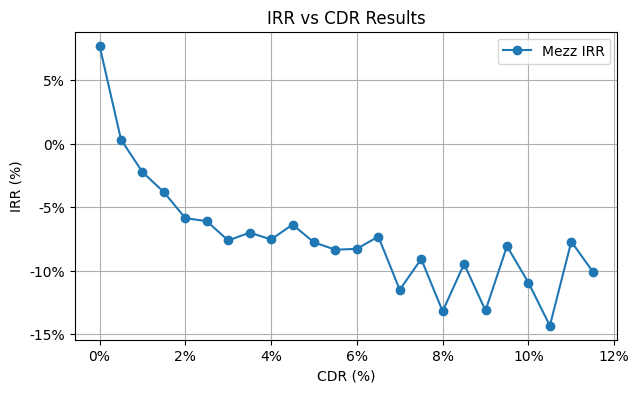

In [171]:
# Chart
df = results.copy()
df['CDR'] = df['CDR'].str.rstrip('%').astype('float')
df['IRR_E'] = df['IRR_E'].str.rstrip('%').astype('float') / 100
df['IRR_M'] = df['IRR_M'].str.rstrip('%').astype('float') / 100
plt.figure(figsize=(7, 4))
plt.plot(df['CDR'], df['IRR_M'], label='Mezz IRR', marker='o')
x_ticks = np.arange(0, df['CDR'].max() + 2, 2) 
plt.xticks(x_ticks) 
plt.xlabel('CDR (%)')
plt.ylabel('IRR (%)')
plt.title('IRR vs CDR Results')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))  # X-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))  # Y-axis as percentage
plt.legend()
plt.grid(True)
plt.show()

New Template

In [172]:
# from pyxirr import xirr
# r1['pool']['flow'].Loss.sum()
# r1['accounts']['srtAcc'].loc[lambda df: df.memo == "<Support:originator>"].head()
# r1['accounts']['srtAcc'].loc[lambda df: df.memo == "<Support:originator>"].change.sum()

def calcIRR(df, init):
    investDate,investAmount = init
    ds = [investDate] + df.index.to_list()
    vs = [investAmount] + df.cash.to_list()
    return xirr(ds, vs)

calcIRR(r['bonds']['B'], ("2021-06-15",-200))


from lenses import lens

myAssumption = ("Pool",("Mortgage",None,None,None,None)
                                ,None
                                ,None)
myAssumption2 = myAssumption & lens[1][2].set({"CPR":0.01})
myAssumption3 = myAssumption & lens[1][2].set({"CPR":0.02})


rs = localAPI.runByScenarios(srt01
                            ,poolAssump={"CPR-0":myAssumption
                                        ,"CPR-1":myAssumption2
                                        ,"CPR-2":myAssumption3
                                       }
                            ,read=True)


from absbox import readMultiFlowsByScenarios
readMultiFlowsByScenarios(rs, (lens['pool']['flow'],["Balance",'Prepayment'])).head()


import toolz as tz

tz.valmap(lambda x: calcIRR(x['bonds']['B'], ("2021-06-15",-200)), rs)


myAssumption = ("Pool",("Mortgage",None,None,None,None)
                                ,None
                                ,None)
myAssumption2 = myAssumption & lens[1][1].set({"CDR":0.01})
myAssumption3 = myAssumption & lens[1][1].set({"CDR":0.02})


rs = localAPI.runByScenarios(srt01
                            ,poolAssump={"CDR-0":myAssumption
                                        ,"CDR-1":myAssumption2
                                        ,"CDR-2":myAssumption3
                                       }
                            ,read=True)


from absbox import readMultiFlowsByScenarios
readMultiFlowsByScenarios(rs, (lens['pool']['flow'],["Balance",'Default'])).head()



def unHedgeAmount(x:dict):
    "x is the single run result"
    
    poolLoss = x['pool']['flow'].Loss.sum()
    hedgedAmount = x['accounts']['srtAcc'].loc[lambda df: df.memo == "<Support:originator>"].change.sum()
    
    return max(poolLoss - hedgedAmount,0)

tz.valmap(unHedgeAmount, rs)


firstLossTranche = 5

formulaToCurLoss = ("excess", ("cumPoolNetLoss",)
                            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc"))
                            , ("originalBondBalance","C"))

KeyError: 'B'

In [3]:
# Pool assumptions 
original_pool_balance = 1_000_000
original_pool_term = 72
seasoning = 0
base_rate = 0 # float(prcEnv.ratesCurves['EUR'].instFwd(valDate.addTenor('0D')))
pool_rate = 0.03 + base_rate
default_rate = 0.0013     #0.002  #[0.03]*36 + [0.01]*36    # [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
# defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
pool_cpr = 0.15  # amortization rate, 12 / original_pool_term 
recovery_rate = 0.00  # 1 - (0.3 * 0.7 + 0.15 * 0.3)  
recovery_lag = 0   

# Deal assumptions
start_date = '2024-11-15'
original_deal_term = 60
repay_month = 3
months_to_call = repay_month
tranche_size_equity = 0.005
tranche_size_mezz = 0.051
tranche_size_senior = 1 - tranche_size_equity - tranche_size_mezz
tranche_rate_equity = 0.00 + base_rate   
tranche_rate_mezz = 0.07 + base_rate
tranche_rate_senior = 0
issue_price = 1
reinvestment_rate = 0.00
switch_trigger = "cumPoolNetLossRate"   # [("cumPoolDefaultedRate",),">",0.05]] 
switch_level = 0.02 
clean_up_call = 0.1

# Remaining calcs
first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+3)  
first_pay_date = first_pay_date.strftime('%Y-%m-%d')
repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
repay_date = repay_date.strftime('%Y-%m-%d')  
deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
deal_call_date = deal_call_date.strftime('%Y-%m-%d')  
pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  

In [31]:
seniorBalance = 9_440
mezzBalance = 510
firstLossTranche = 50
opb = 10_000
srtTrancheBal = mezzBalance
mezzRate = 0.07
clean_up_call = 0.1
srtRate = 0.08
closingDate = "2024-11-15"
periodPrincipal = ("curPoolCollection", None, "Principal","Prepayment","Recovery")
currentDefaults = ("curPoolCollection", None, "Defaults")
reinvestRate = 0.00
formulaToCurLoss = ("excess", ("cumPoolNetLoss",)
                            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc"))
                            , ("originalBondBalance","C"))

srt02 = Generic("SRT Example"
    ,{"cutoff":"2024-11-15","closing":closingDate,"firstPay":"2024-12-15","payFreq":"QuarterEnd","poolFreq":"QuarterEnd","stated":"2032-11-15"}
    ,{'assets':[["Loan",{"originBalance":opb,"originRate":["fix",0.045],"originTerm":28,"freq":"Quarterly","type":"i_p","originDate":"2024-12-15"}
          ,{"currentBalance":opb,"currentRate":0.08,"remainTerm":28,"status":"current"}]],}
    ,(("acc01",{"balance":0})
      ,("srtAcc",{"balance":0.0,"interest":{"period":"QuarterEnd","rate":reinvestRate,"lastSettleDate":closingDate}})
      ,("dummy",{"balance":100e20})
      ,("acc02",{"balance":0})
     )
    ,(("A1",{"balance":seniorBalance,"rate":0.00,"originBalance":seniorBalance,"originRate":0.00,"startDate":closingDate,"rateType":{"Fixed":0.00},"bondType":{"Sequential":None}})
      ,("B",{"balance":0,"rate":mezzRate,"originBalance":0,"originRate":mezzRate,"startDate":closingDate,"rateType":{"Fixed":mezzRate},"bondType":{"Sequential":None}})
      ,("C",{"balance":firstLossTranche,"rate":0.0,"originBalance":firstLossTranche,"originRate":0.0,"startDate":closingDate,"rateType":{"Fixed":0.0},"bondType":{"Sequential":None}}))
    ,tuple()
    ,{"default":[ # pay prorata t"A1","C"o senior and SRT tranch
         ["calcInt","B","A1","C"]
         ,["payInt","dummy",["B","A1","C"]]
         ,["If",["<=","2025-04-01"]
               ,["buyAsset",["Current|Defaulted", 1.0, 0],"acc02",None,]
          ]
         ,["IfElse",["status", "Accelerated"]
                   ,[["payPrinBySeq","acc02",["A1","B","C"]
                     ,{"limit":{"formula":("bondBalance",)}}]
                    ]
                   ,[["payPrin","acc02",["A1","B","C"]]]
                    ]
         ,["writeOff", "C", {"formula": ("min",("curPoolCollection", None, "Defaults"),("bondBalance","C"))}]
         ,["writeOff", "B", {"formula": ("min",
                                         ("excess",("cumPoolDefaultedBalance",),("originalBondBalance","C")),
                                         ("curPoolCollection", None, "Defaults"),
                                         ("bondBalance","B"),
                                         )
                                        }]
      ],
      "closingDay":[["fundWith","srtAcc","B",{"formula":("const",srtTrancheBal)}]],
      "endOfCollection":[["liqRepayResidual","srtAcc", "originator", {"formula":formulaToCurLoss}]],
      "cleanUp":[#["payIntResidual","srtAcc","B"]
                 ]}    # draw loss amount and pay to originator
    ,[#["CollectedInterest","acc01"]
      ["CollectedPrincipal","acc02"]
        ,["CollectedPrepayment","acc02"]
        ,["CollectedRecoveries","acc02"]]
    ,{"originator":{"lineOfCredit":20000,"type": {"total": 20000} , "start": closingDate}}
    ,None
    ,None
    ,{"AfterCollect":{
         "DR_trigger":{
                    "condition": [("cumPoolDefaultedRate",),">", 0.005],
                    "effects": ("newStatus", "Accelerated"),
                    "status": False,
                    "curable": False,
                }
        }
    }
    ,("PreClosing","Amortizing"))

# revolvingPool = (["constant",mortgage1],("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None))
perf = ("Pool",("Loan",None,None,None,None),None,None) 

runDealAssump = [("revolving",["constant",
                                ["Loan"     
                                ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"i_p","originDate":repay_date}
                                ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term,"status":"current"}]
                                ]
                               ,perf)
                ,("call",{"poolFactor":clean_up_call})
                ,("inspect",("MonthEnd",("excess", ("cumPoolNetLoss",)
                    , ("abs",("accountTxnAmount","<Support:originator>","srtAcc"))
                    , ("constant",firstLossTranche))))]


In [29]:
["Loan"     
    ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"i_p","originDate":repay_date}
    ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term,"status":"current"}]

['Loan',
 {'originBalance': 1000000,
  'originRate': ['fix', 0.03],
  'originTerm': 72,
  'freq': 'Monthly',
  'type': 'i_p',
  'originDate': '2025-02-15'},
 {'currentBalance': 1000000,
  'currentRate': 0.03,
  'remainTerm': 72,
  'status': 'current'}]

In [41]:
from absbox import EnginePath

localAPI = API(EnginePath.DEV,check=False)

Connecting engine server -> https://absbox.org/api/dev

✅Connected, local lib:0.28.7, server:0.29.10

In [42]:
r0 = localAPI.run(srt02,poolAssump=("Pool",("Loan", {"CDR":0.0055}, {"CPR":0.15}, None, None),None,None)
                # ,runAssump=[("call",("poolFactor",0.10)),("inspect",("MonthEnd",("excess", ("cumPoolNetLoss",)
                #            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc")), ("constant",firstLossTranche))))]
                ,runAssump=runDealAssump,read=True)

Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Account acc02 has cash to be distributed
Account dummy has cash to be distributed
Account srtAcc has cash to be distributed
LiquidityProvider originator is not paid off

In [24]:
r0['result']['status']

,Date,From,To
0,2024-11-15,PreClosing,Amortizing
1,2025-12-31,Amortizing,Accelerated
2,2031-12-31,Accelerated,Called
3,2031-12-31,DealEnd,Clean Up


In [34]:
72/12

6.0

In [38]:
r0['accounts']['acc02']

,balance,change,memo
date,,,
2024-11-15,0.000,0.000,<Pool:CollectedRecoveries>
2024-11-15,0.000,0.000,<Pool:CollectedPrepayment>
2024-11-15,0.000,0.000,<Pool:CollectedPrincipal>
2024-12-15,0.000,0.000,"<PurchaseAsset:Consol,0.00>"
2024-12-15,0.000,0.000,"<PayPrin:A1,B,C>"
2024-12-31,0.000,0.000,<Pool:CollectedRecoveries>
2024-12-31,0.000,0.000,<Pool:CollectedPrepayment>
2024-12-31,0.000,0.000,<Pool:CollectedPrincipal>
2024-12-31,0.000,0.000,"<PurchaseAsset:Consol,0.00>"


In [37]:
392.27 / 143.530

2.7330174876332474

In [43]:
r0['pool']['flow']

,Balance,Principal,Interest,Prepayment,Default,Recovery,Loss,WAC,CumPrincipal,CumPrepay,CumDelinq,CumDefault,CumRecovery,CumLoss
Date,,,,,,,,,,,,,,
2024-11-15,"10,000.000",0.000,0.000,0.000,0.000,0,0.000,0.080,0.000,0.000,0,0.000,0,0.000
2024-12-31,"10,000.000",0.000,0.000,0.000,0.000,0,0.000,0.080,0.000,0.000,0,0.000,0,0.000
2025-03-31,"9,594.150",0.000,189.250,392.270,13.580,0,13.580,0.080,0.000,392.270,0,13.580,0,13.580
2025-06-30,"9,588.570",0.000,188.340,384.530,13.320,0,13.320,0.053,0.000,776.800,0,26.900,0,26.900
2025-09-30,"9,207.210",0.000,180.680,368.590,12.770,0,12.770,0.053,0.000,"1,145.390",0,39.670,0,39.670
2025-12-31,"8,845.560",0.000,171.540,349.540,12.110,0,12.110,0.053,0.000,"1,494.930",0,51.780,0,51.780
2026-03-31,"8,502.480",0.000,162.860,331.600,11.480,0,11.480,0.053,0.000,"1,826.530",0,63.260,0,63.260
2026-06-30,"8,166.170",0.000,159.660,325.050,11.260,0,11.260,0.053,0.000,"2,151.580",0,74.520,0,74.520
2026-09-30,"7,843.800",0.000,153.190,311.580,10.790,0,10.790,0.053,0.000,"2,463.160",0,85.310,0,85.310


In [223]:
from pyxirr import xirr

In [224]:
dates = ["2024-11-15"]+r0['bonds']['B'].index.to_list()
cash = [-510]+r0['bonds']['B'].cash.to_list()
xirr(np.array([dates, cash]))

-0.0002718316372274642

In [187]:
r0['accounts']['acc02'].loc["2031-12-31"]

,balance,change,memo
date,,,
2031-12-31,0.000,0.000,<Pool:CollectedRecoveries>
2031-12-31,131.300,131.300,<Pool:CollectedPrepayment>
2031-12-31,"3,306.760","3,175.460",<Pool:CollectedPrincipal>
2031-12-31,0.000,"-3,306.760","<PayPrin:A1,B,C>"


In [206]:
r0['bonds']['A1']

,balance,interest,principal,rate,cash,intDue,intOverInt,factor,memo
date,,,,,,,,,
2024-12-15,"9,440.000",0,0.000,0,0.000,0,0,1.000,"[<PayInt:A1>, <PayPrin:A1>]"
2024-12-31,"9,440.000",0,0.000,0,0.000,0,0,1.000,"[<PayInt:A1>, <PayPrin:A1>]"
2025-03-31,"9,440.000",0,0.000,0,0.000,0,0,1.000,"[<PayInt:A1>, <PayPrin:A1>]"
2025-06-30,"9,061.410",0,378.590,0,378.590,0,0,0.960,"[<PayInt:A1>, <PayPrin:A1>]"
2025-09-30,"8,697.860",0,363.550,0,363.550,0,0,0.921,"[<PayInt:A1>, <PayPrin:A1>]"
2025-12-31,"8,352.460",0,345.400,0,345.400,0,0,0.885,"[<PayInt:A1>, <PayPrin:A1>]"
2026-03-31,"8,024.480",0,327.980,0,327.980,0,0,0.850,"[<PayInt:A1>, <PayPrin:A1>]"
2026-06-30,"7,702.660",0,321.820,0,321.820,0,0,0.816,"[<PayInt:A1>, <PayPrin:A1>]"
2026-09-30,"7,393.620",0,309.040,0,309.040,0,0,0.783,"[<PayInt:A1>, <PayPrin:A1>]"


In [164]:
from absbox import readBondsCf
readBondsCf(r0['bonds'])

Bond              A1                                            B            \
Field        balance interest principal  rate      cash   balance  interest   
date                                                                          
2024-11-15       NaN      NaN       NaN   NaN       NaN 5,100.000     0.000   
2024-12-15 9,440.000    0.000     0.000 0.000     0.000 5,100.000     0.000   
2024-12-31 9,440.000    0.000     0.000 0.000     0.000 5,100.000     0.000   
2025-03-31 9,440.000    0.000     0.000 0.000     0.000 5,100.000     0.000   
2025-06-30 9,440.000    0.000     0.000 0.000     0.000 5,100.000     0.000   
2025-09-30 9,219.430    0.000   220.570 0.000   220.570 4,980.850     0.000   
2025-12-31 9,011.010    0.000   208.420 0.000   208.420 4,868.260     0.000   
2026-03-31 9,011.010    0.000     0.000 0.000     0.000 4,868.260     0.000   
2026-06-30 9,011.010    0.000     0.000 0.000     0.000 4,599.570     0.000   
2026-09-30 9,011.010    0.000     0.000 0.000     0.000 4,311.990     0.000   
2026-12-31 9,011.010    0.000     0.000 0.000     0.000 4,042.360     0.000   
2027-03-31 9,011.010    0.000     0.000 0.000     0.000 3,789.450     0.000   
2027-06-30 9,011.010    0.000     0.000 0.000     0.000 3,481.260     0.000   
2027-09-30 9,011.010    0.000     0.000 0.000     0.000 3,173.750     0.000   
2027-12-31 9,011.010    0.000     0.000 0.000     0.000 2,885.470     0.000   
2028-03-31 9,011.010    0.000     0.000 0.000     0.000 2,612.150     0.000   
2028-06-30 9,011.010    0.000     0.000 0.000     0.000 2,350.240     0.000   
2028-09-30 9,011.010    0.000     0.000 0.000     0.000 2,102.070     0.000   
2028-12-31 9,011.010    0.000     0.000 0.000     0.000 1,869.410     0.000   
2029-03-31 9,011.010    0.000     0.000 0.000     0.000 1,651.190     0.000   
2029-06-30 9,011.010    0.000     0.000 0.000     0.000 1,439.700     0.000   
2029-09-30 9,011.010    0.000     0.000 0.000     0.000 1,239.310     0.000   
2029-12-31 9,011.010    0.000     0.000 0.000     0.000 1,051.440     0.000   
2030-03-31 9,011.010    0.000     0.000 0.000     0.000   875.230     0.000   
2030-06-30 9,011.010    0.000     0.000 0.000     0.000   704.450     0.000   
2030-09-30 9,011.010    0.000     0.000 0.000     0.000   542.630     0.000   
2030-12-31 9,011.010    0.000     0.000 0.000     0.000   390.930     0.000   
2031-03-31 8,906.600    0.000   104.410 0.000   104.410     0.000     0.000   
2031-06-30 8,426.610    0.000   479.990 0.000   479.990     0.000     0.000   
2031-09-30 8,327.930    0.000    98.680 0.000    98.680     0.000     0.000   
2031-12-31 5,997.860    0.000 2,330.070 0.000 2,330.070     0.000 4,149.860   

Bond                                        C                                   
Field       principal  rate      cash balance interest principal  rate    cash  
date                                                                            
2024-11-15 -5,100.000 0.000     0.000     NaN      NaN       NaN   NaN     NaN  
2024-12-15      0.000 0.000     0.000 950.000    0.000     0.000 0.000   0.000  
2024-12-31      0.000 0.000     0.000 950.000    0.000     0.000 0.000   0.000  
2025-03-31      0.000 0.000     0.000 824.320    0.000     0.000 0.000   0.000  
2025-06-30      0.000 0.000     0.000 702.470    0.000     0.000 0.000   0.000  
2025-09-30    119.150 0.000   119.150 570.600    0.000    16.410 0.000  16.410  
2025-12-31    112.590 0.000   112.590 449.490    0.000    12.890 0.000  12.890  
2026-03-31      0.000 0.000     0.000  34.810    0.000   313.200 0.000 313.200  
2026-06-30    268.690 0.000   268.690   0.000    0.000    34.810 0.000  34.810  
2026-09-30    287.580 0.000   287.580     NaN      NaN       NaN   NaN     NaN  
2026-12-31    269.630 0.000   269.630     NaN      NaN       NaN   NaN     NaN  
2027-03-31    252.910 0.000   252.910     NaN      NaN       NaN   NaN     NaN  
2027-06-30    245.080 0.000   245.080     NaN      NaN       NaN   NaN     NaN  
2027-09-30    232

In [104]:
(1-(1-0.15)**(1/4) )* 10_000.000

398.1541059581217

In [105]:
(1-(1-0.15)**(1/4) )* 9_607.200

382.51461267608676

In [106]:
(1-(1-0.15)**(1/4) )* 9_221.610

367.1621885044475

In [107]:
(1-(1-0.15)**(1/4) )* 8_851.500

352.42610688883144

In [108]:
352.42610688883144+367.1621885044475+382.51461267608676+398.1541059581217

1500.2570140274875

In [193]:
r0['pool']['flow'].CumDefault / r0['pool']['flow'].Balance[0]

Date
2024-11-15   0.000
2024-12-31   0.000
2025-03-31   0.000
2025-06-30   0.001
2025-09-30   0.001
2025-12-31   0.001
2026-03-31   0.002
2026-06-30   0.002
2026-09-30   0.002
2026-12-31   0.002
2027-03-31   0.003
2027-06-30   0.003
2027-09-30   0.003
2027-12-31   0.003
2028-03-31   0.003
2028-06-30   0.004
2028-09-30   0.004
2028-12-31   0.004
2029-03-31   0.004
2029-06-30   0.004
2029-09-30   0.005
2029-12-31   0.005
2030-03-31   0.005
2030-06-30   0.005
2030-09-30   0.005
2030-12-31   0.005
2031-03-31   0.005
2031-06-30   0.005
2031-09-30   0.006
2031-12-31   0.006
Name: CumDefault, dtype: float64

In [93]:
r0['result']['status']

,Date,From,To
0,2024-11-15,PreClosing,Amortizing
1,2030-01-01,DealEnd,Stop: Stated Maturity


In [ ]:
r02 = localAPI.run(srt02,poolAssump=("Pool",("Mortgage", None, None, None, None),None,None)
                # ,runAssump=[("call",("poolFactor",0.10)),("inspect",("MonthEnd",("excess", ("cumPoolNetLoss",)
                #            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc")), ("constant",firstLossTranche))))]
                ,runAssump=runDealAssump,read=True)

In [55]:
r02['bonds']['B'].principal.sum(),r03['bonds']['B'].principal.sum()

(-343.47, -394.52)

In [56]:
r02['bonds']['B']

,balance,interest,principal,rate,cash,intDue,intOverInt,factor,memo
date,,,,,,,,,
2024-11-15,510.000,0.000,-510.000,0.000,0.000,0,0,None,"<FundWith:B,510.00>"
2024-12-15,510.000,2.930,0.000,0.070,2.930,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2024-12-20,510.000,0.480,0.000,0.070,0.480,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2025-01-20,510.000,3.030,0.000,0.070,3.030,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2025-02-20,504.440,3.030,5.560,0.070,8.590,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2025-03-20,498.860,2.700,5.580,0.070,8.280,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2025-04-20,493.250,2.960,5.610,0.070,8.570,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2025-05-20,487.610,2.830,5.640,0.070,8.470,0,0,None,"[<PayInt:B>, <PayPrin:B>]"
2025-06-20,481.940,2.890,5.670,0.070,8.560,0,0,None,"[<PayInt:B>, <PayPrin:B>]"


In [12]:
r02 = localAPI.run(srt02,poolAssump=("Pool",("Mortgage", None, None, None, None),None,None)
                # ,runAssump=[("call",("poolFactor",0.10)),("inspect",("MonthEnd",("excess", ("cumPoolNetLoss",)
                #            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc")), ("constant",firstLossTranche))))]
                ,runAssump=runDealAssump,read=True)

bond_cf = readBondsCf(r02['bonds'])
bond_cf.iloc[0, bond_cf.columns.get_loc(('B', 'cash'))] = default_ratedefault_ratedefault_rate-bond_cf.iloc[0, bond_cf.columns.get_loc(('B', 'balance'))]
bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'cash'))] = bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'balance'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'interest'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'principal'))]
bond_cf.tail()
result = xirr(bond_cf.index.to_list(), bond_cf['B', 'cash'].to_list())
result
# results.append({'pool_cpr': pool_cpr*100, 'tranche_rate_mezz': tranche_rate_mezz*100, 'IRR': result*100})
# print(f"Pool CPR: {pool_cpr*100}, Tranche Rate: {tranche_rate_mezz*100}, IRR: {result*100}")

AbsboxError: ❌ Failed to talk to server http://localhost:8081/runDeal

In [175]:
# Sensitivity Test v2 Using readBondsCf(r['bonds'])
cprs = np.arange(0.00, 0.35, 0.05).tolist()
spreads = np.arange(0.04, 0.08, 0.005).tolist()
results = []

for pool_cpr in cprs:
   for tranche_rate_mezz in spreads:
        perf = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None) 
        runDealAssump = [("revolving",["constant",["Mortgage"     
                        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term,"freq":"Monthly","type":"Level","originDate":repay_date}
                        ,{"currentBalance":original_pool_balance,"currentRate":pool_rate,"remainTerm":original_pool_term,"status":"current"}]],perf)
                        ,("call",{"poolFactor":clean_up_call})
                        ,("inspect",("MonthEnd",("excess", ("cumPoolNetLoss",)
                            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc"))
                            , ("constant",firstLossTranche))))]

        r02 = localAPI.run(srt02,poolAssump=("Pool",("Mortgage", {"CDR":default_rate}, None, None, None),None,None)
                        # ,runAssump=[("call",("poolFactor",0.10)),("inspect",("MonthEnd",("excess", ("cumPoolNetLoss",)
                        #            , ("abs",("accountTxnAmount","<Support:originator>","srtAcc")), ("constant",firstLossTranche))))]
                        ,runAssump=runDealAssump,read=True)

        bond_cf = readBondsCf(r02['bonds'])
        bond_cf.iloc[0, bond_cf.columns.get_loc(('B', 'cash'))] = -bond_cf.iloc[0, bond_cf.columns.get_loc(('B', 'balance'))]
        bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'cash'))] = bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'balance'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'interest'))] + bond_cf.iloc[-1, bond_cf.columns.get_loc(('B', 'principal'))]
        bond_cf.tail()
        result = xirr(bond_cf.index.to_list(), bond_cf['B', 'cash'].to_list())
        results.append({'pool_cpr': pool_cpr*100, 'tranche_rate_mezz': tranche_rate_mezz*100, 'IRR': result*100})
        print(f"Pool CPR: {pool_cpr*100}, Tranche Rate: {tranche_rate_mezz*100}, IRR: {result*100}")


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 0.0, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 5.0, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 10.0, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 15.000000000000002, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 20.0, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 25.0, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 4.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 4.5, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 5.0, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 5.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 5.999999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 6.499999999999999, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 6.999999999999998, IRR: 7.208550302008485


Warning Message from server:
Bond A1 is not paid off
Bond B is not paid off
Bond C is not paid off
Account acc01 has cash to be distributed
LiquidityProvider originator is not paid off

Pool CPR: 30.000000000000004, Tranche Rate: 7.499999999999998, IRR: 7.208550302008485


In [176]:
results_df = pd.DataFrame(results)
results_df.to_clipboard()
results_df

,pool_cpr,tranche_rate_mezz,IRR
0,0.000,4.000,7.209
1,0.000,4.500,7.209
2,0.000,5.000,7.209
3,0.000,5.500,7.209
4,0.000,6.000,7.209
5,0.000,6.500,7.209
6,0.000,7.000,7.209
7,0.000,7.500,7.209
8,5.000,4.000,7.209
9,5.000,4.500,7.209


In [ ]:
pd.concat([r02['accounts']['srtAcc'],r02['pool']['flow'].CumLoss.to_frame()]).sort_index().loc["2021-09-30"]

In [ ]:
firstLossTrancheDraft = {"FirstLoss-1": 5,"FirstLoss-2":10,"FirstLoss-3":20}

In [ ]:
import toolz as tz
dealDrafts = tz.valmap(lambda x: srt02 & lens.bonds[2][1].Fork(lens['balance'],lens['originBalance']).set(x) 
                     ,firstLossTrancheDraft)

In [ ]:
rm02 = localAPI.runStructs(dealDrafts
                        ,poolAssump=("Pool",("Mortgage", {"CDR":0.01}, None, None, None)
                                           ,None
                                           ,None)
                        ,nonPoolAssump=[("call",("poolFactor",0.10))
                                   ,("inspect"
                                     ,("MonthEnd",("excess", ("cumPoolNetLoss",)
                                                         , ("abs",("accountTxnAmount","<Support:originator>","srtAcc"))
                                                         , ("constant",firstLossTranche))
                                                  ))
                                    ]
                        ,read=True)

In [ ]:
def calcIRR(df, init):
    investDate,investAmount = init
    ds = [investDate] + df.index.to_list()
    vs = [investAmount] + df.cash.to_list()
    return xirr(ds, vs)

tz.valmap(lambda x: calcIRR(x['bonds']['B'], ("2021-06-15",-200)), rm02)

EXPERIMENTAL CASE: PROCEED WITH CAUTION!!! DEFAULT RATES & TRANCHE THICKNESS

In [ ]:
pauyse here

print('\nModel Test Results: DEFAULT RATES AND TRANCHE THICKNESS')

# LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# original_balance = 1000000000
default_rates = np.arange(0.005, 0.05, 0.001).tolist()  
tranche_size_equitys = np.arange(0.08, 0.12, 0.0025).tolist()  
df = pd.DataFrame(columns=['Constant Default Rate', 'Tranche Size', 'IRR'])  

for default_rate in default_rates:
    for tranche_size_equity in tranche_size_equitys:
        perf = ("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None)

        r = localAPI.run(test01,runAssump = runDealAssump
                        ,poolAssump = ("Pool",("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None),None,None)
                        ,read=True)

        projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
        a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
        df = df.append({'Constant Default Rate': default_rate, 'Tranche Size': tranche_size_equity, 'IRR': a}, ignore_index=True)
        print('Default Rate: ', default_rate, ' & Tranche Size: ', tranche_size_equity, ' & IRR: ', a)

Sanity Check

1. put in a super simple portfolio, set default rate to 0, then make sure it gives the right IRR 
2. do not tranche it yet, but put in default rate, make sure IRR is close to original IRR - defaults 
3. then play with recovery, then tranche it 
4. set it up to have both attach and detach 
5. test to make sure cashflow logic is really tight
6. projectCf['netCashflow'].sum() - projectCf['cashAccountBal'].iloc[0] + projectCf['cashAccountBal'].iloc[-1]
7. make sure simple changes that should change the cashflow schedule, make sure model is working as expected